# Feature engineering

In [407]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('../data/all_data_cleaned.csv')

De volgende measurements hebben we van *alle* transportation modes:

In [346]:
# Columns with values for every label (transportation mode)
# - all columns with _kalman at the end
usable_cols = [col for col in data.columns if col.endswith('_kalman')]
usable_cols


['Latitude (°)_kalman',
 'Longitude (°)_kalman',
 'Horizontal Accuracy (m)_kalman',
 'Acceleration x (m/s^2)_kalman',
 'Acceleration y (m/s^2)_kalman',
 'Acceleration z (m/s^2)_kalman',
 'Gyroscope x (rad/s)_kalman',
 'Gyroscope y (rad/s)_kalman',
 'Gyroscope z (rad/s)_kalman']

In [ ]:
# Create some graphs of the measurement data per transportation_mode
import matplotlib.pyplot as plt
import seaborn as sns

# for measurement in usable_cols:
#     plt.figure(figsize=(10,6))
#     sns.boxplot(y=measurement, x='transportation_mode', data=data)
#     plt.show()


# Create new feature total accelleration

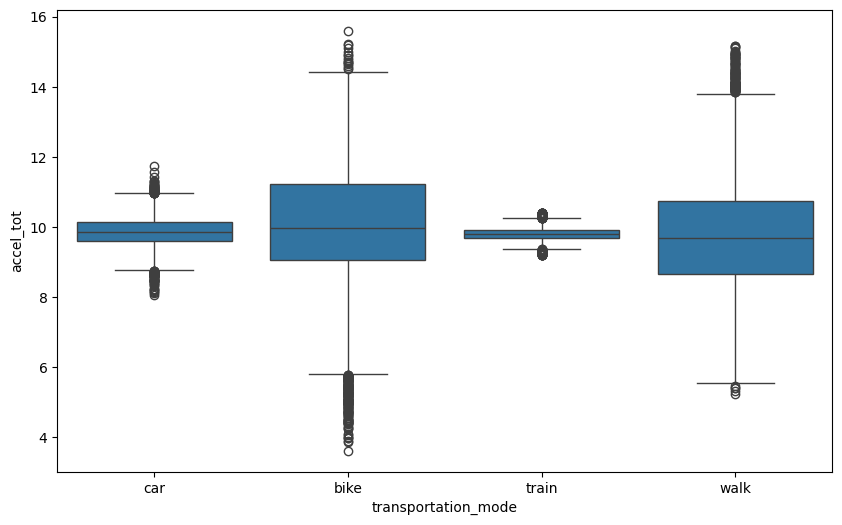

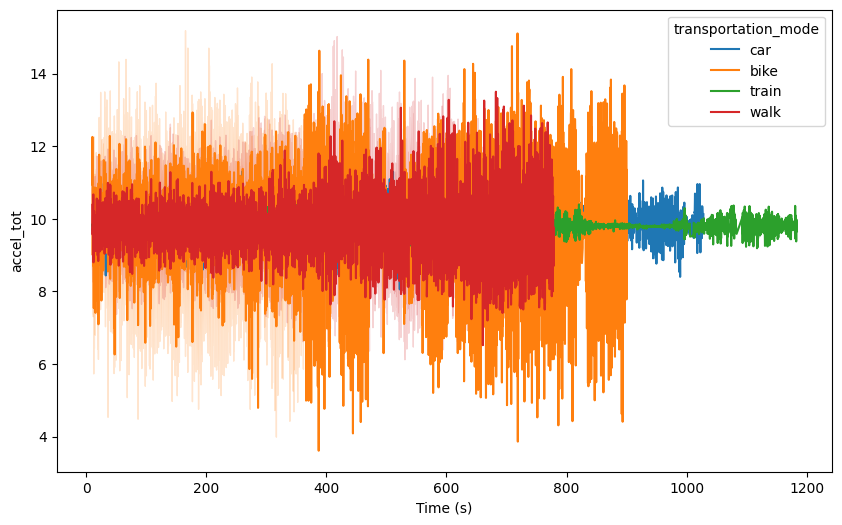

In [409]:
data['accel_tot'] = np.sqrt(np.square(data['Acceleration x (m/s^2)']) + np.square(data['Acceleration y (m/s^2)']) + np.square(data['Acceleration z (m/s^2)']))

plt.figure(figsize=(10,6))
sns.boxplot(y='accel_tot', x='transportation_mode', data=data)
plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(y='accel_tot', x='Time (s)', hue='transportation_mode', data=data)
plt.show()

# plt.figure(figsize=(10,6))
# sns.lineplot(y='Acceleration x (m/s^2)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()

# plt.figure(figsize=(10,6))
# sns.lineplot(y='Acceleration y (m/s^2)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()


# plt.figure(figsize=(10,6))
# sns.lineplot(y='Acceleration z (m/s^2)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()

Aan deze figuren te zien twijfel ik of we hier iets mee kunnen. Wat opvalt: 
* Walk/bike hebben grotere *variance* in acceleration, hier kunnen we misschien iets mee (maar vind het raar, zou het andersom verwachten)
* de mean acceleration is hetzelfde (wat ik ook raar vind), hier kunnen we dus niets mee

# Variance of acceleration

In [410]:
ROLLING_WINDOWS = [4, 30, 60] # 0.25s per row = 1s, 7.5s, 15s

for window in ROLLING_WINDOWS:
    data[f'accel_var_{round(window * 0.25)}s'] = data['accel_tot'].rolling(window=window).mean()

mean_by_category = data.groupby('transportation_mode')['accel_var_1s'].mean()
print(mean_by_category)

transportation_mode
bike     9.905697
car      9.852392
train    9.805314
walk     9.840638
Name: accel_var_1s, dtype: float64


Dus bike/walk hebben duidelijk grotere variance van acceleration

# Create feature displacement (delta x)

In [411]:
from geopy.distance import geodesic
from math import isnan

LAT_COL = "Latitude (°)"
LONG_COL = "Longitude (°)"

# 60 lamb = 15 seconds
def calculate_delta_x_per_experiment(data, lamb=60):
    """
    Calculate the distance between the current row and the row lamb rows before it,
    for each experiment separately.

    Parameters
    ----------
    data : pd.DataFrame
        The data to calculate the distance for.
    lamb : int
        The number of rows to look back to calculate the distance. Each row is assumed to be
        250ms apart.
    """
    data['delta_x'] = np.nan

    for experiment in data['expirement_id'].unique():
        experiment_data = data[data['expirement_id'] == experiment]
        for i in range(1, len(experiment_data)):
            if i - lamb < 0:
                data.loc[experiment_data.index[i], 'delta_x'] = np.nan
                continue
            lat1 = experiment_data.iloc[i][LAT_COL]
            lon1 = experiment_data.iloc[i][LONG_COL]
            lat2 = experiment_data.iloc[i - lamb][LAT_COL]
            lon2 = experiment_data.iloc[i - lamb][LONG_COL]

            if isnan(lat1) or isnan(lon1) or isnan(lat2) or isnan(lon2):
                data.loc[experiment_data.index[i], 'delta_x'] = np.nan
                continue

            distance = geodesic((lat1, lon1), (lat2, lon2)).m

            # We want to remove outliers from the data
            if distance > 1000:
                data.loc[experiment_data.index[i], 'delta_x'] = np.nan
                continue

            data.loc[experiment_data.index[i], 'delta_x'] = distance

    return data

data = calculate_delta_x_per_experiment(data)


In [355]:
print(data.shape)
print(data["Longitude (°)"].isnull().sum(), data["Latitude (°)"].isnull().sum())

(33539, 26)
26792 26709


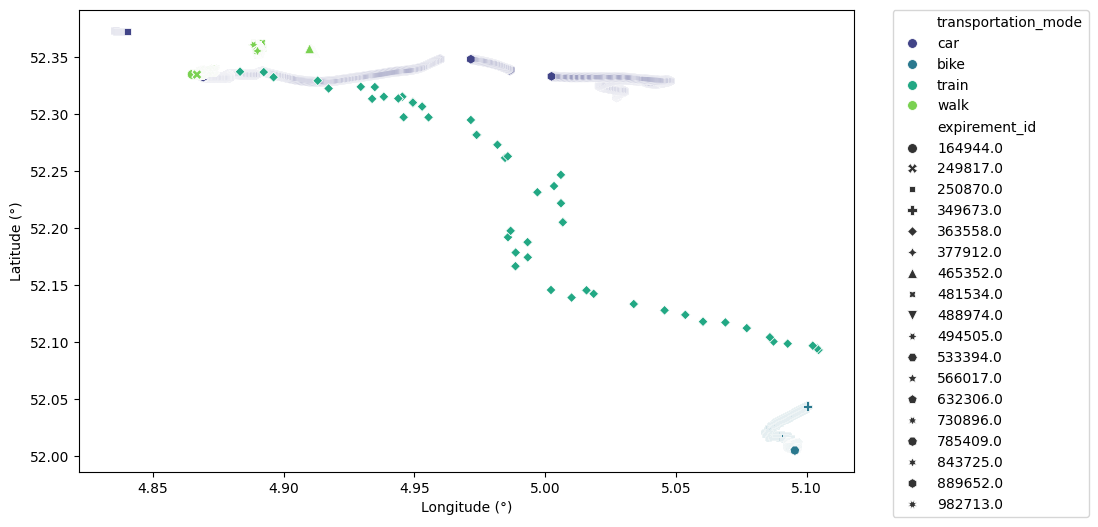

In [340]:
# Show longitude and latitude for train 
plt.figure(figsize=(10,6))

# show difference in color per expirement as well
sns.scatterplot(x='Longitude (°)', y='Latitude (°)', hue='transportation_mode', data=data, style="expirement_id", s=50, palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

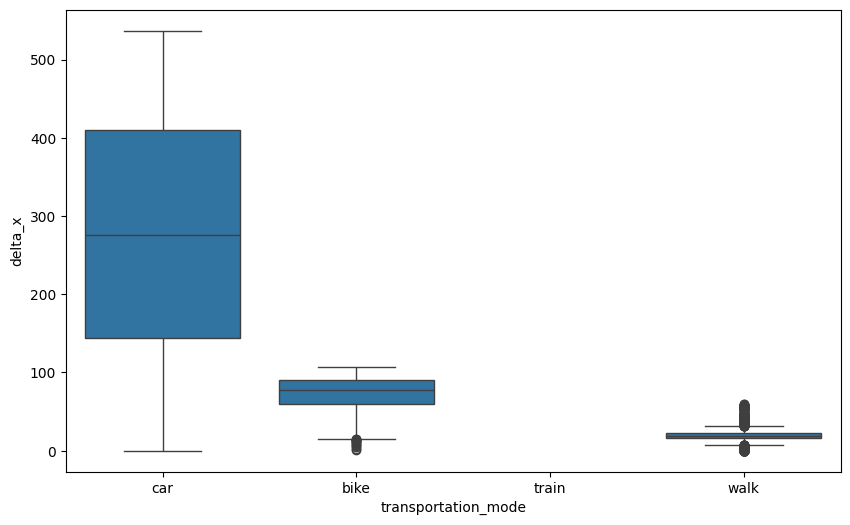

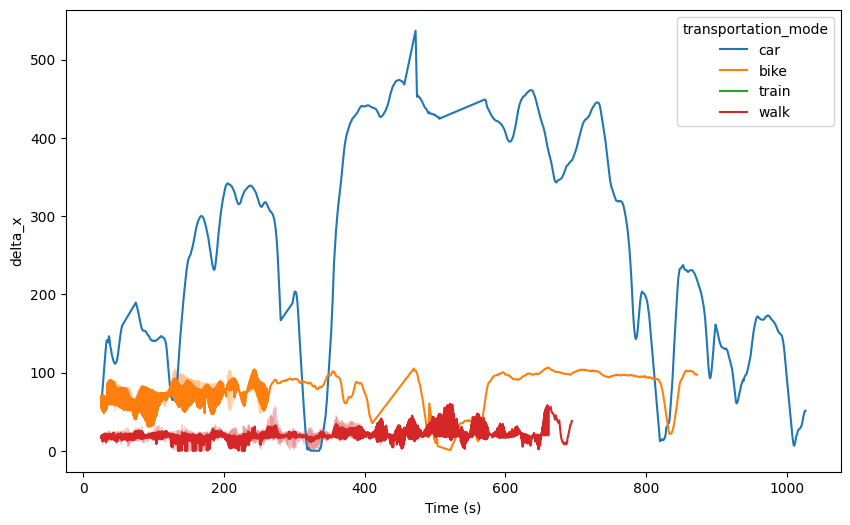

In [372]:

# Show the delta_x per transportation mode
plt.figure(figsize=(10,6))
sns.boxplot(y='delta_x', x='transportation_mode', data=data)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='delta_x', x='Time (s)', hue='transportation_mode', data=data)
plt.show()


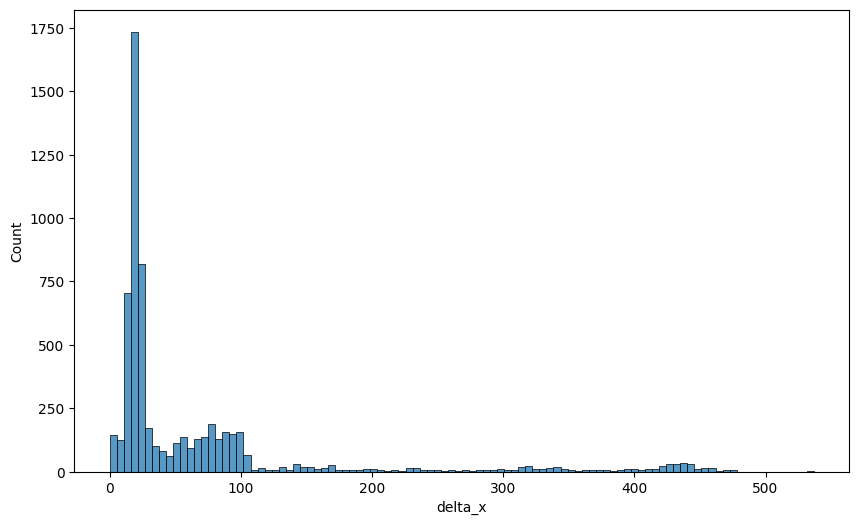

In [373]:
# Show distribution of Delta x
plt.figure(figsize=(10,6))
sns.histplot(data['delta_x'].dropna(), bins=100)
plt.show()

# Create feature Velocity

In [412]:

# Calculate velocity
data['velocity_new_(m/s)'] = data['delta_x'] / 15

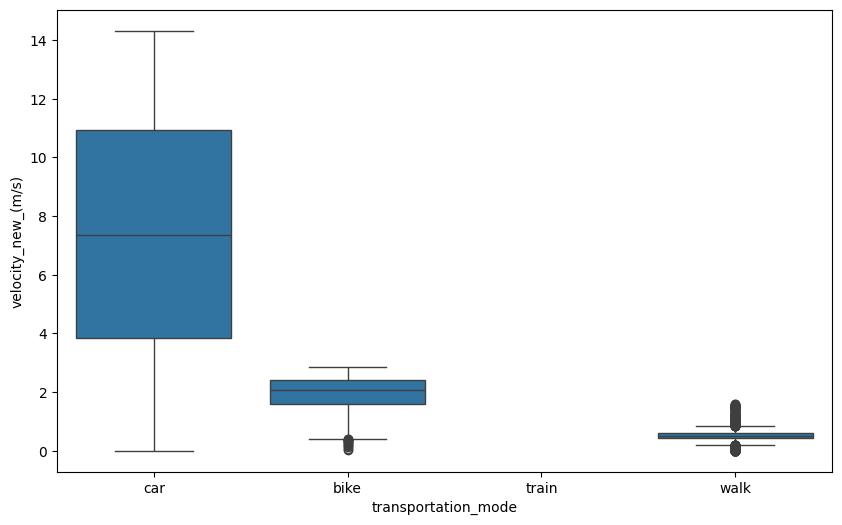

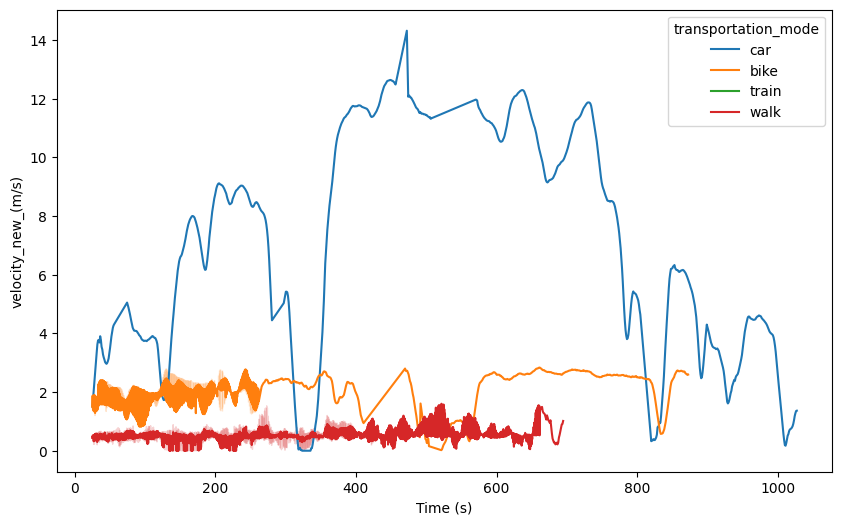

In [382]:
plt.figure(figsize=(10,6))
sns.boxplot(y='velocity_new_(m/s)', x='transportation_mode', data=data)
plt.show()

# plt.figure(figsize=(10,6))
# sns.boxplot(y='Velocity (m/s)', x='transportation_mode', data=data)
# plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(y='velocity_new_(m/s)', x='Time (s)', hue='transportation_mode', data=data)
plt.show()

# plt.figure(figsize=(10,6))
# sns.lineplot(y='Velocity (m/s)', x='Time (s)', hue='transportation_mode', data=data)
# plt.show()

Om de een of andere reden houden we geen displacement (en dus geen velocity) over voor 'train' data, ik snap niet waarom. De grafieken hieronder (nu uit-gecomment) suggereren dat er wel voldoende latitude/longitude info van 'train' moet zijn

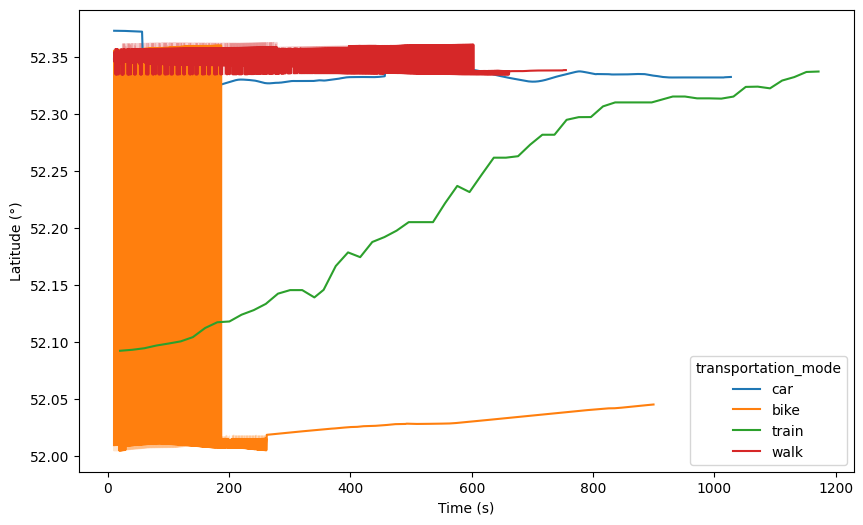

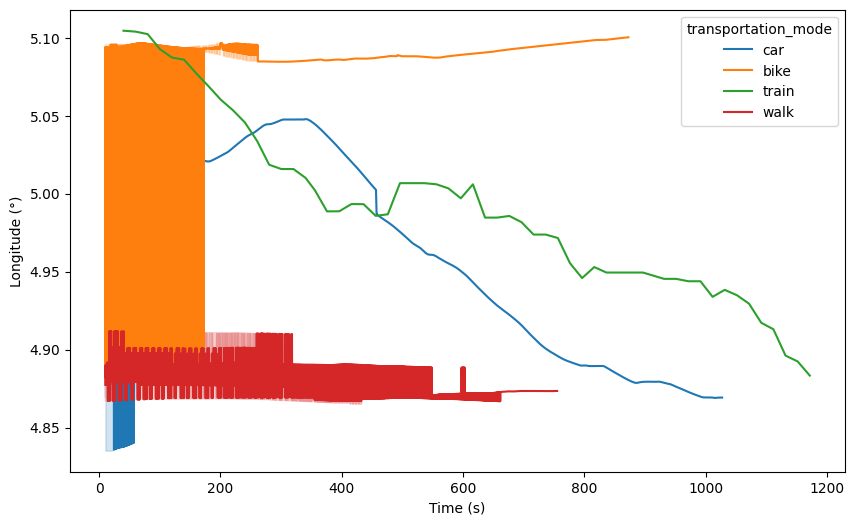

In [383]:
plt.figure(figsize=(10,6))
sns.lineplot(y='Latitude (°)', x='Time (s)', hue='transportation_mode', data=data)
# plt.savefig(f'{measurement}.png')
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='Longitude (°)', x='Time (s)', hue='transportation_mode', data=data)
# plt.savefig(f'{measurement}.png')
plt.show()

# Create feature jerk


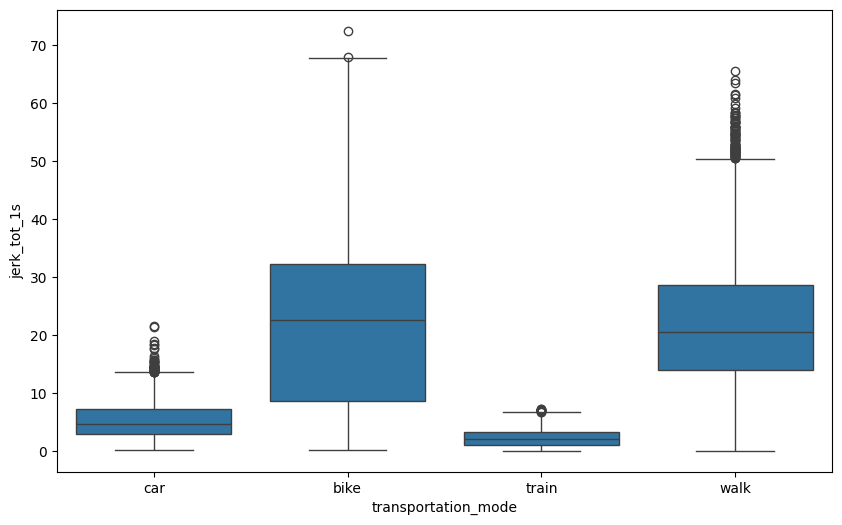

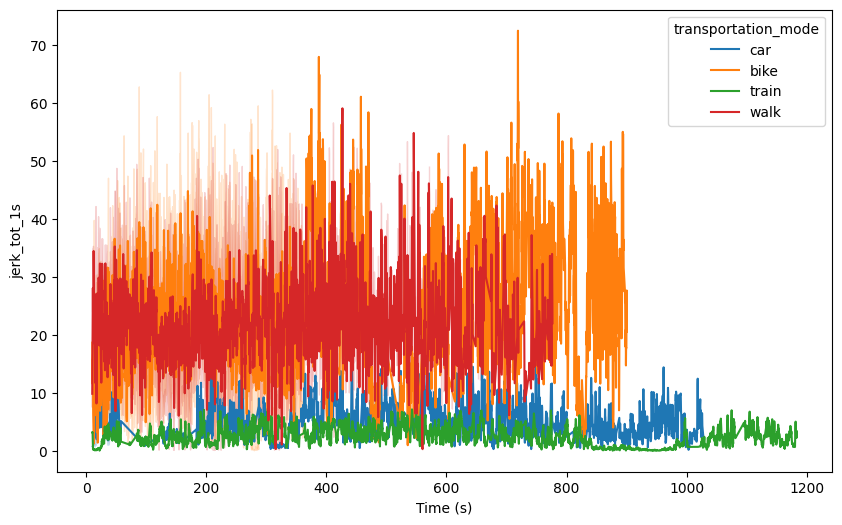

In [413]:
# Constant which sets the window size for the rolling mean
# we create features for 1 sec, 7.5 sec and 15 sec
# (0.25s * 4), (0.25s * 30), (0.25s * 60) per row
ROLLING_WINDOWS = [4, 30, 60]

for window in ROLLING_WINDOWS:
    data[f'jerk_tot_{round(window*0.25)}s'] = abs(data['accel_tot'].diff() / 0.1).rolling(window=window).mean()

plt.figure(figsize=(10,6))
sns.boxplot(y='jerk_tot_1s', x='transportation_mode', data=data)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='jerk_tot_1s', x='Time (s)', hue='transportation_mode', data=data)
plt.show()


In [414]:
data.columns

Index(['time', 'Time (s)', 'Latitude (°)', 'Longitude (°)',
       'Horizontal Accuracy (m)', 'expirement_id', 'Acceleration x (m/s^2)',
       'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)',
       'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)', 'Gyroscope z (rad/s)',
       'start_date', 'transportation_mode', 'Latitude (°)_kalman',
       'Longitude (°)_kalman', 'Horizontal Accuracy (m)_kalman',
       'Acceleration x (m/s^2)_kalman', 'Acceleration y (m/s^2)_kalman',
       'Acceleration z (m/s^2)_kalman', 'Gyroscope x (rad/s)_kalman',
       'Gyroscope y (rad/s)_kalman', 'Gyroscope z (rad/s)_kalman', 'accel_tot',
       'accel_var_1s', 'accel_var_8s', 'accel_var_15s', 'delta_x',
       'velocity_new_(m/s)', 'jerk_tot_1s', 'jerk_tot_8s', 'jerk_tot_15s'],
      dtype='object')

In [416]:
# Create some features which are based on past values
# - rolling mean of the acceleration
# - rolling mean of the velocity
# - rolling mean of the delta_x
# - rolling mean of the jerk
# - rolling mean of the acceleration variance
# - rolling mean of the delta_x variance
# - rolling mean of the velocity variance
# - rolling mean of the jerk variance

# Constant which sets the window size for the rolling mean
# we create features for 1 sec, 7.5 sec and 15 sec
# (0.25s * 4), (0.25s * 30), (0.25s * 60) per row
ROLLING_WINDOWS = [4, 30, 60]

for window in ROLLING_WINDOWS:
    data[f'accel_tot_{round(window*0.25)}s'] = data['accel_tot'].rolling(window=window).mean()
    data[f'velocity_new_{round(window*0.25)}s'] = data['velocity_new_(m/s)'].rolling(window=window).mean()
    data[f'delta_x_{round(window*0.25)}s'] = data['delta_x'].rolling(window=window).mean()

In [ ]:
data.columns

In [417]:


# Export the data
data.to_csv('../data/all_data_featured.csv', index=False)